In [1]:
library(tidyverse)
library(readxl)
library(vcfR)
library(VariantAnnotation)
library(rtracklayer)
library(Biostrings)
library(Rsamtools)

data = read_csv("../data/annotated-calls.csv")
data = data %>% filter(AF < 0.40, Dx != "ASD")
cov_info = read_tsv("../data/BSM_MSSM_SCZ_coverage.txt", col_names = c("ID","Dx","mean_cov"))
data = data %>% mutate(subjectID = str_split(`Individual ID`,"_",n=2,simplify=TRUE)[,2]) 
cov_info$subjectID = unlist(lapply(strsplit(cov_info$ID,"_"), function(x) {paste(x[1:2],collapse="_")}))

data$mean_cov = cov_info$mean_cov[match(data$subjectID,cov_info$subjectID)]
data = data %>% filter(Dataset == "Chess")

## filter outlier
# data = data %>% filter(`Individual ID` != "CMC_MSSM_224") 

── Attaching packages ───────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ──────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()


   *****       ***   vcfR   ***       *****
   This is vcfR 1.12.0 
     browseVignettes('vcfR') # Documentation
     citation('vcfR') # Citation
   *****       *****      *****       *****


Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplic

In [2]:
make_vcf <- function(data){
    c <- paste0("chr",data$CHROM)
    s <- data$POS 
    e <- as.integer(s+sapply(as.character(data$REF),nchar, simplify="array")-1)
    g <- GRanges(c, IRanges(s,e))
    v <- VCF(rowRanges=g)
    ref(v) <- DNAStringSet(data$REF)
    alt(v) <- DNAStringSetList(lapply(data$ALT, function(x){x}))
    mcols(v)$subject = data$`Individual ID`
    mcols(v)$VAF = data$AF
    return(v)
}

v_all = make_vcf(data)
v_scz = make_vcf(data %>% filter(Dx=="SCZ"))
v_ctrl = make_vcf(data %>% filter(Dx!= "SCZ"))



In [3]:
library(biomaRt)
#ensembl <- useEnsembl(biomart = "genes", dataset = "hsapiens_gene_ensembl")
# cts <- read_csv("../resources//genes_matrix_csv/expression_matrix.csv",col_names = FALSE)
# gene_names <- read_csv("../resources/genes_matrix_csv/rows_metadata.csv")

listMarts(host="grch37.ensembl.org")
mart <- useEnsembl(biomart="ensembl", dataset="hsapiens_gene_ensembl", GRCh=37, mirror="useast")
att <- listAttributes(mart)

transcripts <- getBM(attributes=c("chromosome_name", "transcript_start", "transcript_end", "strand",
                                  "ensembl_gene_id","transcription_start_site","hgnc_symbol"),mart=mart)



Warning message:
“Ensembl will soon enforce the use of https.
Ensure the 'host' argument includes "https://"”


biomart,version
<chr>,<chr>
ENSEMBL_MART_ENSEMBL,Ensembl Genes 105
ENSEMBL_MART_SNP,Ensembl Variation 105
ENSEMBL_MART_FUNCGEN,Ensembl Regulation 105


Warning message:
“version or GRCh arguments cannot be used together with the mirror argument.
We will ignore the mirror argument and connect to the main Ensembl site.”


In [4]:
library(regioneR)
transcripts.gr <- toGRanges(transcripts)

#Filter out non-standard chromosomes
transcripts.gr <- keepSeqlevels(transcripts.gr, c(1:22,"X", "Y"), pruning.mode = "coarse")
colnames(mcols(transcripts.gr)) <- c("STRAND","ensembl_gene_id","transcription_start_site","hgnc_symbol")
## get the longest transcript
rd = splitAsList(transcripts.gr, transcripts.gr$ensembl_gene_id)
maxwd = which.max(width(rd))
refgene.longest = rd[splitAsList(unname(maxwd), names(maxwd))]

transcript.gr = unlist(refgene.longest)
seqlevelsStyle(transcript.gr) <- "UCSC"

In [5]:
ref_genome <- "BSgenome.Hsapiens.UCSC.hg19"
library(ref_genome, character.only = TRUE)
library(plyranges)


Loading required package: BSgenome


Attaching package: ‘plyranges’


The following object is masked from ‘package:biomaRt’:

    select


The following object is masked from ‘package:VariantAnnotation’:

    select


The following object is masked from ‘package:XVector’:

    slice


The following object is masked from ‘package:IRanges’:

    slice


The following objects are masked from ‘package:dplyr’:

    between, n, n_distinct


The following object is masked from ‘package:stats’:

    filter




In [6]:
## Get all the TF sites
tf_files = system("ls ../resources/hg19_cistrome/*.A.bed",intern = TRUE)
length(tf_files)

tf = lapply(tf_files, function(x){
    tmp = rtracklayer::import(x,format="BED")
    tf_name = gsub(pattern = "../resources/hg19_cistrome/|_HUMAN.A.bed",replacement = "",x = x)
    tmp$tf_name = tf_name
    #tmp = keepSeqlevels(tmp, c(paste0("chr",1:22),"chrX","chrY"), pruning.mode = "fine")
    seqlevelsStyle(tmp) <- "UCSC"
    return(tmp)
})

tf = keepSeqlevels(GRangesList(tf), c(paste0("chr",1:22),"chrX","chrY"), pruning.mode = "tidy")
tf_final = do.call("c",tf)
tf_final = tf_final[!duplicated(tf_final)]

[1] 138

## Figure 4A

In [7]:
library(liftOver)

rate_ratio_base <- function(v_target, b,tf_ranges, d=100, in_tss=FALSE){
    extension = 1
    dinuc_context <- as.character(Biostrings::getSeq(
    BSgenome::getBSgenome(ref_genome),
    seqnames(v_target),
    start(v_target) - extension,
    end(v_target) + extension
    ))

    v_target$dn = dinuc_context
    plus_cg = c("ACG","CCG","GCG","TCG")
    neg_cg = c("CGA","CGC","CGG","CGT")
    
    v_target = v_target %>% filter(dn %in% plus_cg | dn %in% neg_cg)
    
    gwide.seq = getSeq(BSgenome.Hsapiens.UCSC.hg19)
    gwide_sites = sum(dinucleotideFrequency(gwide.seq)[,c("CG","GC")])
    base_muts = v_target[ (v_target$REF == b[1] & as.character(unlist(v_target$ALT)) == b[2] & v_target$dn %in% plus_cg) | 
                  (v_target$REF == b[3] & as.character(unlist(v_target$ALT)) == b[4] & v_target$dn %in% neg_cg)]
    gwide_muts = length(base_muts)
    df = as.data.frame(transcript.gr)

    tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                                              end=df$transcription_start_site),strand=df$STRAND)

    tss.gr = flank(tss.gr, width = 2500 + width(tss.gr),start = TRUE)
    
    dhs = rtracklayer::import("../resources/E081-DNase.hotspot.fdr0.01.broad.bed.gz")
    dhs$ntile = ntile(dhs$score, 20)
    dhs = dhs[dhs$ntile==20]
    if(in_tss){
        epi_promoter = tf_ranges %>% filter_by_overlaps(dhs) %>% filter_by_overlaps(tss.gr) %>% reduce_ranges()
    } else{
        epi_promoter = tf_ranges %>% filter_by_overlaps(dhs) %>% reduce_ranges()
    }
    epi_promoter = resize(epi_promoter, width = d, fix="center")
    
    reg_seqs = getSeq(BSgenome.Hsapiens.UCSC.hg19,epi_promoter)
    reg_sites = sum(dinucleotideFrequency(reg_seqs)[,c("CG","GC")])
    epi_promoter$intarget = countOverlaps(epi_promoter,base_muts, ignore.strand=TRUE)
    reg_muts = sum(epi_promoter$intarget)
    return(c(reg_muts = reg_muts, gwide_muts=gwide_muts, reg_sites=reg_sites, gwide_sites=gwide_sites))

}


Loading required package: gwascat

gwascat loaded.  Use makeCurrentGwascat() to extract current image.

 from EBI.  The data folder of this package has some legacy extracts.

Loading required package: Homo.sapiens

Loading required package: AnnotationDbi


Attaching package: ‘AnnotationDbi’


The following object is masked from ‘package:plyranges’:

    select


The following object is masked from ‘package:dplyr’:

    select


Loading required package: OrganismDbi

Loading required package: GenomicFeatures

Loading required package: GO.db



Loading required package: org.Hs.eg.db



Loading required package: TxDb.Hsapiens.UCSC.hg19.knownGene



In [8]:
library(parallel)

base_list = list(c("C","A","G","T"),
                c("C","G","G","C"),
                c("C","T","G","A"))

get_base_change_ratios2 <- function(b){
    dist_from_tss = c(5000,2000,1000,500,100)
    stats_df = mclapply(dist_from_tss, function(x){
        return(rate_ratio_base(granges(v_scz),b, tf_final, 2*x, in_tss=TRUE))
    })
    stats_df = do.call(rbind,stats_df)
    print(stats_df)
    stats_df = stats_df %>% data.frame() %>% mutate(muts = reg_muts - c(.$reg_muts[2:length(dist_from_tss)],0))
    stats_df = stats_df %>% mutate(dists = dist_from_tss, RR=0, low_ci=0, high_ci=0, pval=0)
    for(i in 1:nrow(stats_df)){
        res = poisson.test(c(stats_df$muts[i], stats_df$gwide_muts[i]), c(stats_df$reg_sites[i], stats_df$gwide_sites[i]))
        stats_df$RR[i] = res$estimate; stats_df$low_ci[i] = res$conf.int[1]; stats_df$high_ci[i] = res$conf.int[2]
        stats_df$pval[i] = res$p.value
    }
    stats_df$base_change = paste0(b[1], ">",b[2])
    return(stats_df)
}


base_df = lapply(base_list, function(x){ get_base_change_ratios2(x)})

full_stat = do.call(rbind, base_df)
full_stat = full_stat %>% mutate(base_change = factor(base_change, levels=c("C>A","C>G","C>T"))) %>%
    mutate(dists = factor(dists, levels= c(5000,2000,1000,500,100)))

options(repr.plot.width=8, repr.plot.height=4)
p1=full_stat %>% ggplot(aes(x=dists, y=RR)) + 
    geom_pointrange(aes(color=base_change,ymin=low_ci, ymax= high_ci), size=1, show.legend = FALSE) +
    geom_line(aes(group=base_change, color=base_change), show.legend = FALSE) +
    theme_classic(16) + geom_hline(yintercept = 1,linetype=2, size=1) +
    theme(axis.text.x = element_text(angle=45, hjust=1, vjust=1)) +
        labs(x="Distance to TFBS+DHS+promoter at non-CpG sites",color="Base Change", y="Rate Ratio") +
    facet_wrap(.~base_change, nrow=1,ncol=6) +
    scale_color_manual(values = c("#2EBAED", "#000000", "#DE1C14")) +
    scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","0-0.1Kb"))
full_stat

## Get the rate ratios for SCZ


base_list = list(c("C","A","G","T"),
                c("C","G","G","C"),
                c("C","T","G","A"))

library(parallel)
get_base_change_ratios2 <- function(b){
    dist_from_tss = c(5000,2000,1000,500,100)
    stats_df = mclapply(dist_from_tss, function(x){
        return(rate_ratio_base(granges(v_scz),b, tf_final, 2*x, in_tss=FALSE))
    })
    stats_df = do.call(rbind,stats_df)
    stats_df = stats_df %>% data.frame() %>% mutate(muts = reg_muts - c(.$reg_muts[2:length(dist_from_tss)],0))
    stats_df = stats_df %>% mutate(dists = dist_from_tss, RR=0, low_ci=0, high_ci=0, pval=0)
    for(i in 1:nrow(stats_df)){
        res = poisson.test(c(stats_df$muts[i], stats_df$gwide_muts[i]), c(stats_df$reg_sites[i], stats_df$gwide_sites[i]))
        stats_df$RR[i] = res$estimate; stats_df$low_ci[i] = res$conf.int[1]; stats_df$high_ci[i] = res$conf.int[2]
        stats_df$pval[i] = res$p.value
    }
    stats_df$base_change = paste0(b[1], ">",b[2])
    return(stats_df)
}


base_df = lapply(base_list, function(x){ get_base_change_ratios2(x)})

full_stat = do.call(rbind, base_df)
full_stat = full_stat %>% mutate(base_change = factor(base_change, levels=c("C>A","C>G","C>T"))) %>%
    mutate(dists = factor(dists, levels= c(5000,2000,1000,500,100)))

options(repr.plot.width=8, repr.plot.height=4)
p2=full_stat %>% ggplot(aes(x=dists, y=RR)) + 
    geom_pointrange(aes(color=base_change,ymin=low_ci, ymax= high_ci), size=1, show.legend = FALSE) +
    geom_line(aes(group=base_change, color=base_change), show.legend = FALSE) +
    theme_classic(16) + geom_hline(yintercept = 1,linetype=2, size=1) +
    theme(axis.text.x = element_text(angle=45, hjust=1, vjust=1)) +
        labs(x="Distance to TFBS+DHS at non-CpG sites",color="Base Change", y="Rate Ratio") +
    facet_wrap(.~base_change, nrow=1,ncol=6) +
    scale_color_manual(values = c("#2EBAED", "#000000", "#DE1C14")) +
    scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","0-0.1Kb"))
    
full_stat



     reg_muts gwide_muts reg_sites gwide_sites
[1,]        0         19   3792613   158048043
[2,]        0         19   1974623   158048043
[3,]        0         19   1296425   158048043
[4,]        0         19    807531   158048043
[5,]        0         19    182491   158048043
     reg_muts gwide_muts reg_sites gwide_sites
[1,]        3         28   3792613   158048043
[2,]        3         28   1974623   158048043
[3,]        2         28   1296425   158048043
[4,]        2         28    807531   158048043
[5,]        2         28    182491   158048043
     reg_muts gwide_muts reg_sites gwide_sites
[1,]        7        542   3792613   158048043
[2,]        4        542   1974623   158048043
[3,]        2        542   1296425   158048043
[4,]        0        542    807531   158048043
[5,]        0        542    182491   158048043


reg_muts,gwide_muts,reg_sites,gwide_sites,muts,dists,RR,low_ci,high_ci,pval,base_change
<int>,<int>,<int>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,19,3792613,158048043,0,5000,0.0000000,0.00000000,8.9296169,1.0000000000,C>A
0,19,1974623,158048043,0,2000,0.0000000,0.00000000,17.1509098,1.0000000000,C>A
0,19,1296425,158048043,0,1000,0.0000000,0.00000000,26.1230546,1.0000000000,C>A
0,19,807531,158048043,0,500,0.0000000,0.00000000,41.9384284,1.0000000000,C>A
0,19,182491,158048043,0,100,0.0000000,0.00000000,185.5794589,1.0000000000,C>A
3,28,3792613,158048043,0,5000,0.0000000,0.00000000,5.8682591,1.0000000000,C>G
3,28,1974623,158048043,1,2000,2.8585573,0.06990732,17.2900595,0.3023766443,C>G
2,28,1296425,158048043,0,1000,0.0000000,0.00000000,17.1672373,1.0000000000,C>G
2,28,807531,158048043,0,500,0.0000000,0.00000000,27.5605960,1.0000000000,C>G


reg_muts,gwide_muts,reg_sites,gwide_sites,muts,dists,RR,low_ci,high_ci,pval,base_change
<int>,<int>,<int>,<int>,<dbl>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,19,6324506,158048043,0,5000,0.0000000,0.00000000,5.3548184,1.000000000,C>A
0,19,3061135,158048043,0,2000,0.0000000,0.00000000,11.0634066,1.000000000,C>A
0,19,1885828,158048043,0,1000,0.0000000,0.00000000,17.9584676,1.000000000,C>A
0,19,1129591,158048043,0,500,0.0000000,0.00000000,29.9812773,1.000000000,C>A
0,19,254639,158048043,0,100,0.0000000,0.00000000,132.9984057,1.000000000,C>A
3,28,6324506,158048043,0,5000,0.0000000,0.00000000,3.5190157,0.626517006,C>G
3,28,3061135,158048043,1,2000,1.8439477,0.04509458,11.1531668,0.426680936,C>G
2,28,1885828,158048043,0,1000,0.0000000,0.00000000,11.8017314,1.000000000,C>G
2,28,1129591,158048043,0,500,0.0000000,0.00000000,19.7027381,1.000000000,C>G


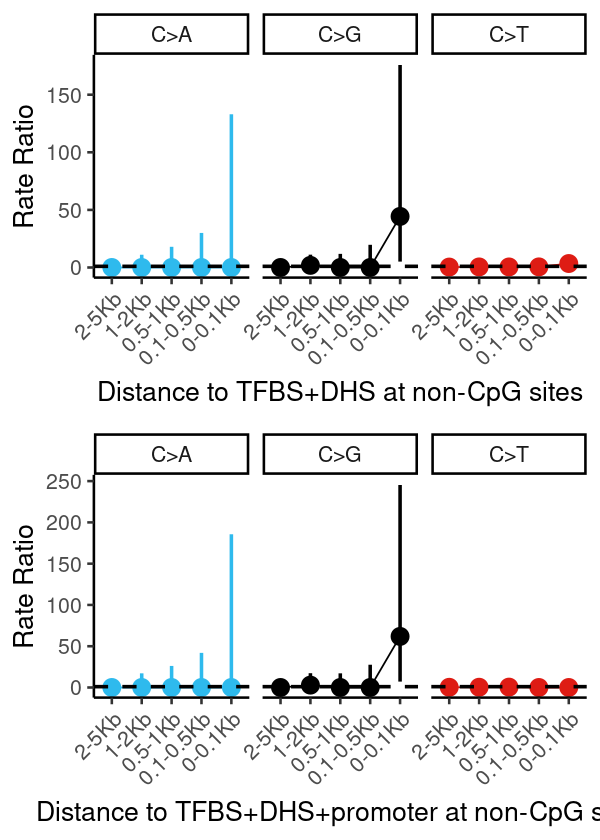

In [9]:
options(repr.plot.width=5, repr.plot.height=7)
p3 = ggpubr::ggarrange(p2,p1, ncol=1, nrow=2)
p3

## Figure 4B

In [10]:
## All other dataset

## Rodin et al dataset
asd_calls = readxl::read_xlsx("../data//rodin_data.xlsx",sheet=4,skip = 1)
make_vcf_asd <- function(data){
    c <- paste0("chr",data$Chromosome)
    s <- data$Position
    e <- as.integer(s+sapply(as.character(data$Ref),nchar, simplify="array")-1)
    g <- GRanges(c, IRanges(s,e))
    v <- VCF(rowRanges=g)
    ref(v) <- DNAStringSet(data$Ref)
    alt(v) <- DNAStringSetList(lapply(data$Alt, function(x){x}))
    mcols(v)$subject = data$`Case ID`
    mcols(v)$VAF = data$VAF
    return(v)
}

# path = system.file(package="liftOver", "extdata", "hg38ToHg19.over.chain")
# ch = import.chain(path)

# to_hg19 <- function(v, ch){
#     v0 = liftOver(v, ch)
#     v0 = unlist(v0)
#     genome(v0) = "hg19"
#     return(v0)
# }


v_all_asd = make_vcf_asd(asd_calls)
v_asd = make_vcf_asd(asd_calls %>% filter(Diagnosis=="ASD"))
v_asd_ctrl = make_vcf_asd(asd_calls %>% filter(Diagnosis!= "ASD"))


In [11]:
## Jonsson et al

twin_mosaic = read_tsv("../resources/Jonsson_etal_mosaic_variants.tsv") %>% filter(nchar(Ref) == 1)
nrow(twin_mosaic)
make_vcf_twin <- function(data){
    c <- paste0(data$Chr)
    s <- data$Pos
    e <- as.integer(s+sapply(as.character(data$Ref),nchar, simplify="array")-1)
    g <- GRanges(c, IRanges(s,e))
    v <- VCF(rowRanges=g)
    ref(v) <- DNAStringSet(data$Ref)
    alt(v) <- DNAStringSetList(lapply(data$Alt, function(x){x}))
    mcols(v)$subject = data$ProbandEnum
    mcols(v)$VAF = data$Proband_AB
    return(v)
}

library(liftOver)
path = system.file(package="liftOver", "extdata", "hg38ToHg19.over.chain")
ch = import.chain(path)

to_hg19 <- function(v, ch){
    v0 = liftOver(v, ch)
    v0 = unlist(v0)
    genome(v0) = "hg19"
    return(v0)
}


v_twin = to_hg19(make_vcf_twin(twin_mosaic), ch)



Rows: 23653 Columns: 8

── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): Chr, Ref, Alt, ProbandEnum
dbl (4): Pos, Proband_AB, ProbandRef, ProbandAlt


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



[1] 20544

In [12]:
v_control_combined = granges(v_ctrl) %>% bind_ranges(granges(v_asd_ctrl)) %>% bind_ranges(v_twin)

In [13]:
library(liftOver)


rate_cg <- function(v_target,tf_ranges, d=100,ca=FALSE, in_tss=FALSE){
    extension = 1
    dinuc_context <- as.character(Biostrings::getSeq(
    BSgenome::getBSgenome(ref_genome),
    seqnames(v_target),
    start(v_target) - extension,
    end(v_target) + extension
    ))

    v_target$dn = dinuc_context
    plus_cg = c("ACG","CCG","GCG","TCG")
    neg_cg = c("CGA","CGC","CGG","CGT")
    gwide.seq = getSeq(BSgenome.Hsapiens.UCSC.hg19)
    gwide_sites = sum(dinucleotideFrequency(gwide.seq)[,c("CG","GC")])
    if(ca){
            cg_muts = v_target %>% filter((REF == "C" & unlist(ALT) == "G" & dn %in% plus_cg ) |
                             (REF == "G" & unlist(ALT) == "C" & dn %in% neg_cg) |
                                 (REF == "C" & unlist(ALT) == "A" & dn %in% plus_cg) | 
                                (REF == "G" & unlist(ALT) == "T" & dn %in% neg_cg))
    } else{
        cg_muts = v_target %>% filter((REF == "C" & unlist(ALT) == "G" & dn %in% plus_cg ) |
                         (REF == "G" & unlist(ALT) == "C" & dn %in% neg_cg) )
    }
    gwide_muts = length(cg_muts)
    df = as.data.frame(transcript.gr)
    tss.gr = GRanges(seqnames = df$seqnames, ranges = IRanges(start = df$transcription_start_site, 
                                                              end=df$transcription_start_site),strand=df$STRAND)

    tss.gr = flank(tss.gr, width = 2500 + width(tss.gr),start = TRUE)

    dhs = rtracklayer::import("../resources/E081-DNase.hotspot.fdr0.01.broad.bed.gz")
    dhs$ntile = ntile(dhs$score, 20)
    dhs = dhs[dhs$ntile==20]
    if(in_tss){
        epi_promoter = tf_ranges %>% filter_by_overlaps(dhs) %>% filter_by_overlaps(tss.gr) %>% reduce_ranges()
    } else{
        epi_promoter = tf_ranges %>% filter_by_overlaps(dhs) %>% reduce_ranges()
    }
    epi_promoter = resize(epi_promoter, width = d, fix="center")
    reg_seqs = getSeq(BSgenome.Hsapiens.UCSC.hg19,epi_promoter)
    reg_sites = sum(dinucleotideFrequency(reg_seqs)[,c("CG","GC")])
    epi_promoter$intarget = countOverlaps(epi_promoter,cg_muts, ignore.strand=TRUE)
    reg_muts = sum(epi_promoter$intarget)

    return(c(reg_muts = reg_muts, gwide_muts=gwide_muts, reg_sites=reg_sites, gwide_sites=gwide_sites))    
}


library(parallel)

get_rate_cg <- function(v_target, t, in_tss){
    dist_from_tss = c(5000,2000,1000,500,100)
    stats_df = mclapply(dist_from_tss, function(x){
        return(rate_cg(v_target, tf_final, 2*x, ca=TRUE, in_tss=in_tss))
    })
    stats_df = do.call(rbind,stats_df)
    stats_df = stats_df %>% data.frame() %>% mutate(muts = reg_muts - c(.$reg_muts[2:length(dist_from_tss)],0))
    stats_df = stats_df %>% mutate(dists = dist_from_tss, RR=0, low_ci=0, high_ci=0, pval=0)
    for(i in 1:nrow(stats_df)){
        res = poisson.test(c(stats_df$muts[i], stats_df$gwide_muts[i]), c(stats_df$reg_sites[i], stats_df$gwide_sites[i]))
        stats_df$RR[i] = res$estimate; stats_df$low_ci[i] = res$conf.int[1]; stats_df$high_ci[i] = res$conf.int[2]
        stats_df$pval[i] = res$p.value
    }

    if(in_tss){
        p = stats_df %>% mutate(dists = factor(dists, levels= c(5000,2000,1000,500,100))) %>% 
            ggplot(aes(x=dists,y=RR)) + geom_pointrange(aes(ymin=low_ci,ymax=high_ci), color="#3C5488FF",size=1) +
            theme_classic(16) +  geom_hline(yintercept = 1,linetype=2, size=1) +
            theme(axis.text.x = element_text(angle=45, hjust=1)) + 
            labs(x="Distance to\nTFBS+DHS+promoter", title= t) +
            scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","0-0.1Kb"))
            
    } else{
        p = stats_df %>% mutate(dists = factor(dists, levels= c(5000,2000,1000,500,100))) %>% 
            ggplot(aes(x=dists,y=RR)) + geom_pointrange(aes(ymin=low_ci,ymax=high_ci), color="#3C5488FF",size=1) +
            theme_classic(16) +  geom_hline(yintercept = 1,linetype=2, size=1) +
            theme(axis.text.x = element_text(angle=45, hjust=1)) + 
            labs(x="Distance to\nTFBS+DHS", title= t) +
            scale_x_discrete(labels=c("2-5Kb","1-2Kb","0.5-1Kb","0.1-0.5Kb","0-0.1Kb"))
    }

    return(list(p=p,stats_df=stats_df))
}

In [14]:
p1 = get_rate_cg(granges(v_scz), "SCZ\nCpG>RpG",in_tss = FALSE)
print(p1$stats_df)
p1 = p1$p
p2 = get_rate_cg(granges(v_scz), "SCZ\nCpG>RpG",in_tss = TRUE)
print(p2$stats_df)
p2=p2$p
p3 = get_rate_cg(granges(v_asd), "ASD\nCpG>RpG",in_tss=FALSE)
print(p3$stats_df)
p3=p3$p
p4 = get_rate_cg(granges(v_asd), "ASD\nCpG>RpG",in_tss=TRUE)
print(p4$stats_df)
p4 = p4$p
p5 = get_rate_cg(v_control_combined, "Aggregated Controls\nCpG>RpG", in_tss=FALSE)
print(p5$stats_df)
p5=p5$p
p6 = get_rate_cg(v_control_combined, "Aggregated Controls\nCpG>RpG", in_tss=TRUE)
print(p6$stats_df)
p6=p6$p

  reg_muts gwide_muts reg_sites gwide_sites muts dists        RR     low_ci
1        3         47   6324506   158048043    0  5000  0.000000 0.00000000
2        3         47   3061135   158048043    1  2000  1.098522 0.02723993
3        2         47   1885828   158048043    0  1000  0.000000 0.00000000
4        2         47   1129591   158048043    0   500  0.000000 0.00000000
5        2         47    254639   158048043    2   100 26.411699 3.10758582
     high_ci        pval
1   2.040393 0.264400723
2   6.426715 0.601797155
3   6.842870 1.000000000
4  11.424025 1.000000000
5 100.861555 0.002893661
  reg_muts gwide_muts reg_sites gwide_sites muts dists       RR     low_ci
1        3         47   3792613   158048043    0  5000  0.00000 0.00000000
2        3         47   1974623   158048043    1  2000  1.70297 0.04222837
3        2         47   1296425   158048043    0  1000  0.00000 0.00000000
4        2         47    807531   158048043    0   500  0.00000 0.00000000
5        2         

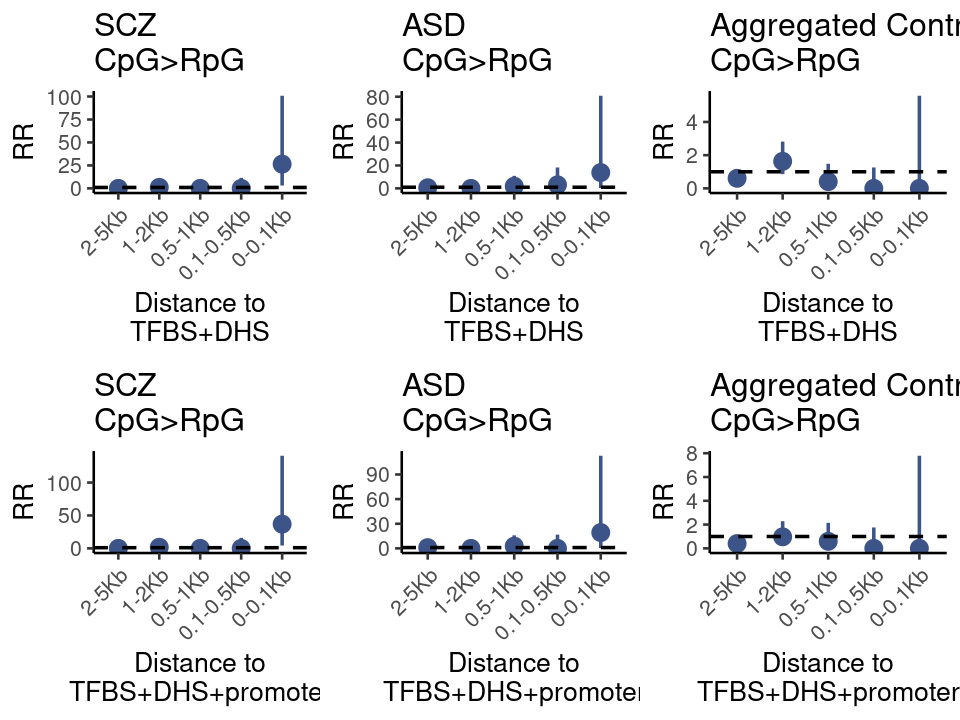

In [15]:
options(repr.plot.width=8, repr.plot.height=6)
pX = ggpubr::ggarrange(p1,p3,p5,p2,p4,p6, nrow=2,ncol=3)
pX

In [16]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /n/app/openblas/0.2.19/lib/libopenblas_core2p-r0.2.19.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] liftOver_1.18.0                        
 [2] Homo.sapiens_1.3.1                     
 [3] TxDb.Hsapiens.UCSC.hg19.knownGene_3.2.2
 [4] org.Hs.eg.db_3.14.0                    
 [5] GO.db_3.14.0                           
 [6] OrganismDbi_1.36.0                     
 [7] GenomicFeatu